# Disease Prediction



## Setup and initialization

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

print(tf.__version__)

# let's set the random seed to make the results reproducible
tf.random.set_seed(299)

2.11.0


In [2]:
#!pip install git+https://github.com/tensorflow/docs

try:
  import tensorflow_docs as tfdocs
  import tensorflow_docs.modeling
  import tensorflow_docs.plots
except:
  !pip install git+https://github.com/tensorflow/docs
  import tensorflow_docs as tfdocs
  import tensorflow_docs.modeling
  import tensorflow_docs.plots
  

In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
# currentdir
import os

logdir = os.path.join(os.getcwd(), "tensorboard_logs")
shutil.rmtree(logdir, ignore_errors=True)

## 1. Dataset Preparation

In [5]:
import pandas as pd


disease_training = pd.read_csv('https://raw.githubusercontent.com/whaldsz/deep-learning/main/Disease_Prediction/Training.csv')
disease_testing = pd.read_csv('https://raw.githubusercontent.com/whaldsz/deep-learning/main/Disease_Prediction/Testing.csv')
disease_training.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [6]:
print(disease_training.shape)
print(disease_testing.shape)

(4920, 134)
(42, 133)


## 3 Remove last column

In [7]:
disease_training.isna().sum()

itching                    0
skin_rash                  0
nodal_skin_eruptions       0
continuous_sneezing        0
shivering                  0
                        ... 
blister                    0
red_sore_around_nose       0
yellow_crust_ooze          0
prognosis                  0
Unnamed: 133            4920
Length: 134, dtype: int64

In [8]:
disease_training.drop('Unnamed: 133', inplace=True, axis=1)

disease_training.isna().sum()

itching                 0
skin_rash               0
nodal_skin_eruptions    0
continuous_sneezing     0
shivering               0
                       ..
inflammatory_nails      0
blister                 0
red_sore_around_nose    0
yellow_crust_ooze       0
prognosis               0
Length: 133, dtype: int64

In [9]:
#disease_training.head()

## Convert category to numeric values

In [10]:
#get class labels

class_names = np.unique(disease_training.prognosis)
disease_training.prognosis = pd.Categorical(disease_training.prognosis)
disease_testing.prognosis = pd.Categorical(disease_testing.prognosis)

In [11]:
#disease_training.prognosis.cat.codes
#disease_training
#disease_testing.head()

# list class names
#class_names[:,None]
class_names

array(['(vertigo) Paroymsal  Positional Vertigo', 'AIDS', 'Acne',
       'Alcoholic hepatitis', 'Allergy', 'Arthritis', 'Bronchial Asthma',
       'Cervical spondylosis', 'Chicken pox', 'Chronic cholestasis',
       'Common Cold', 'Dengue', 'Diabetes ',
       'Dimorphic hemmorhoids(piles)', 'Drug Reaction',
       'Fungal infection', 'GERD', 'Gastroenteritis', 'Heart attack',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E',
       'Hypertension ', 'Hyperthyroidism', 'Hypoglycemia',
       'Hypothyroidism', 'Impetigo', 'Jaundice', 'Malaria', 'Migraine',
       'Osteoarthristis', 'Paralysis (brain hemorrhage)',
       'Peptic ulcer diseae', 'Pneumonia', 'Psoriasis', 'Tuberculosis',
       'Typhoid', 'Urinary tract infection', 'Varicose veins',
       'hepatitis A'], dtype=object)

## Separate Features and Label - Training

### Training Set

In [12]:
X = disease_training.drop('prognosis', axis=1)
y = disease_training.prognosis.cat.codes
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40], dtype=int8)

### Unseen Test Set

In [13]:
X_unseen = disease_testing.drop('prognosis', axis=1)
y_unseen = disease_testing.prognosis.cat.codes
np.unique(X_unseen)

array([0, 1], dtype=int64)

## Split into Training & Validation Test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=74)
#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)


In [15]:
X_train.shape, X_test.shape

((3936, 132), (984, 132))

In [16]:
# Number of features
FEATURES = 132
FEATURES

132

## 2. Model Training

### Training configuration

In [17]:
FEATURES=X_train.shape[1]
N_VALIDATION = X_train.shape[0] *.2 #int(1e3)
N_TRAIN = X_train.shape[0]*.8 #int(1e4)
BUFFER_SIZE = int(100)
BATCH_SIZE = 50
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

[FEATURES, N_VALIDATION, N_TRAIN, BUFFER_SIZE, BATCH_SIZE, STEPS_PER_EPOCH]

[132, 787.2, 3148.8, 100, 50, 62.0]

### Create Model

### Find the ideal learning rate

In [18]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*100,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

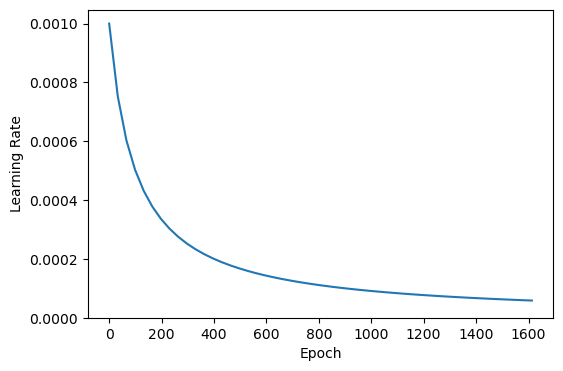

In [19]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (6,4))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [20]:

#metrics = [
#    tfma.metrics.ExampleCount(name='example_count'),
#    tf.keras.metrics.SparseCategoricalCrossentropy(
#        name='sparse_categorical_crossentropy'),
#    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
#    tf.keras.metrics.Precision(name='precision', top_k=1),
#    tf.keras.metrics.Precision(name='precision', top_k=3),
#    tf.keras.metrics.Recall(name='recall', top_k=1),
#    tf.keras.metrics.Recall(name='recall', top_k=3),
#    tfma.metrics.MultiClassConfusionMatrixPlot(
#        name='multi_class_confusion_matrix_plot'),
#]

METRICS = 'accuracy'
LOSS = tf.keras.losses.SparseCategoricalCrossentropy()

### Settings for automation

In [21]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='acc', patience=100),
    tf.keras.callbacks.TensorBoard(os.path.join(logdir,name)),
  ]

In [22]:
def compile_and_fit(model, name, loss=None, optimizer=None, metrics = None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()

  if loss is None:
    loss = LOSS
  if metrics is None:
    metrics = [METRICS]

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics
  )

  model.summary()

  history = model.fit(
    X_train,
    y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_split=0.1,
    #validation_data=[X_test, y_test],
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Models

In [23]:
size_histories = {}

#### Model 1

Simple model with 3 layers

In [24]:
model1 = tf.keras.Sequential([
    layers.Dense(4, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.2),
    layers.Dense(41, activation=tf.keras.activations.softmax)
])

In [25]:
model1_history = compile_and_fit(
    model1, 
    'models/model1',
    loss=LOSS,
    metrics=['acc']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 532       
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 41)                205       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, acc:0.0686,  loss:3.6529,  val_acc:0.1853,  val_loss:3.5670,  
....................................................................................................
Epoch: 100, acc:0.6717,  loss:1.1085,  val_acc:0.9492,  val_loss:0.5517,  
........................................................................

In [26]:

size_histories['model1'] = model1_history

Text(0.5, 0, 'Epochs [Log Scale]')

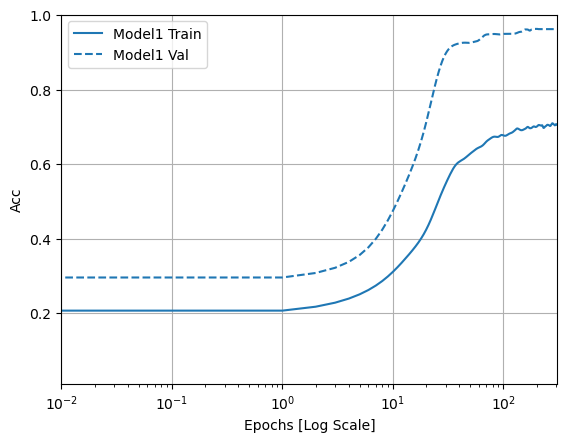

In [27]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc', smoothing_std=10)
plotter.plot(size_histories)
a = plt.xscale('log')

plt.xlim([.01, max(plt.xlim())])
plt.ylim([.01, max(plt.ylim())])
plt.xlabel("Epochs [Log Scale]")

In [28]:
loss, acc = model1.evaluate(X_test, y_test)
print(f"Model Loss (Test Set) : {loss}")
print(f"Model Accuracy (Test Set): {acc}")

31/31 [==============================] - 0s 3ms/step - loss: 0.3083 - acc: 0.9644
Model Loss (Test Set) : 0.3082999289035797
Model Accuracy (Test Set): 0.9644308686256409


#### Model 2

In [29]:
model2 = tf.keras.Sequential([
    layers.Dense(4, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(4, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.2),
    layers.Dense(41, activation=tf.keras.activations.softmax)
])

In [30]:
model2_history = compile_and_fit(
    model2, 
    'models/model2',
    loss=LOSS,
    metrics=['acc']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4)                 532       
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_4 (Dense)             (None, 41)                205       
                                                                 
Total params: 757
Trainable params: 757
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, acc:0.0474,  loss:3.6822,  val_acc:0.1168,  val_loss:3.6118,  
....................................................................................................
Epoch: 100, a

In [31]:
size_histories['model2'] = model2_history

Text(0.5, 0, 'Epochs [Log Scale]')

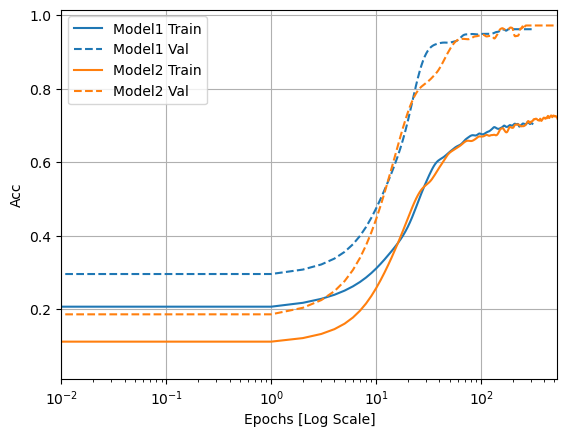

In [32]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc', smoothing_std=10)
plotter.plot(size_histories)
a = plt.xscale('log')

plt.xlim([.01, max(plt.xlim())])
plt.ylim([.01, max(plt.ylim())])
plt.xlabel("Epochs [Log Scale]")

#### Model 3

In [33]:
model3 = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(41, activation=tf.keras.activations.softmax)
])

In [34]:
model3_history = compile_and_fit(
    model3, 
    'models/model3',
    loss=LOSS,
    metrics=['acc']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                8512      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 41)                2665      
                                                                 
Total params: 19,497
Trainable params: 19,497
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, acc:0.6417,  loss:2.5418,  val_acc:0.94

In [35]:

size_histories['model3'] = model3_history

Text(0.5, 0, 'Epochs [Log Scale]')

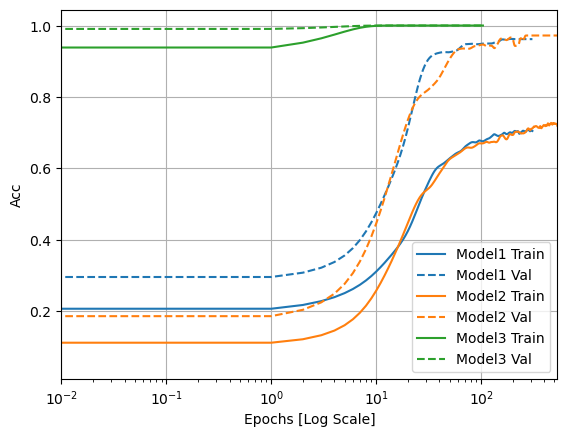

In [36]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc', smoothing_std=10)
plotter.plot(size_histories)
a = plt.xscale('log')

plt.xlim([.01, max(plt.xlim())])
plt.ylim([.01, max(plt.ylim())])
plt.xlabel("Epochs [Log Scale]")

#### Model 4

In [37]:
model4 = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.2),
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(41, activation=tf.keras.activations.softmax)
])


In [38]:
model4_history = compile_and_fit(
    model4, 
    'models/model4',
    loss=LOSS,
    metrics=['acc']
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               68096     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 41)                21033     
                                                                 
Total params: 877,097
Trainable params: 877,097
Non-tr

In [39]:

size_histories['model4'] = model4_history

Text(0.5, 0, 'Epochs [Log Scale]')

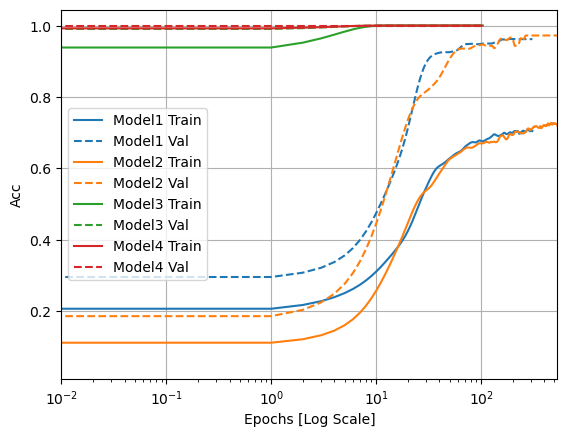

In [40]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc', smoothing_std=10)
plotter.plot(size_histories)
a = plt.xscale('log')

plt.xlim([.01, max(plt.xlim())])
plt.ylim([.01, max(plt.ylim())])
plt.xlabel("Epochs [Log Scale]")

#### Model 5

In [41]:
model5 = tf.keras.Sequential([
    layers.Dense(1024, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1024, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1024, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1024, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(41, activation=tf.keras.activations.softmax)
])

In [42]:
model5_history = compile_and_fit(
    model5, 
    'models/model5',
    loss=LOSS,
    metrics=['acc']
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1024)              136192    
                                                                 
 dense_15 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_16 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_18 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_19 (Dense)            (None, 41)               

In [43]:

size_histories['model5'] = model5_history

Text(0.5, 0, 'Epochs [Log Scale]')

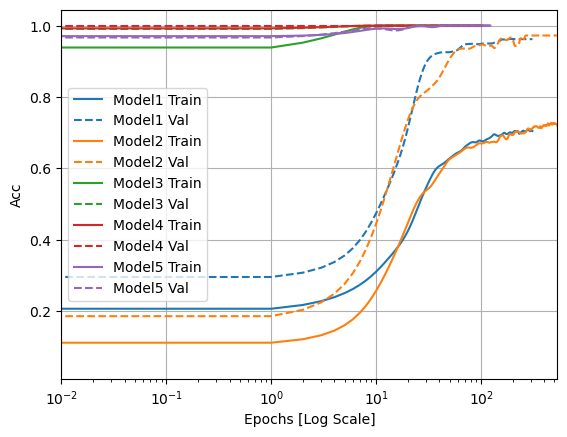

In [44]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc', smoothing_std=10)
plotter.plot(size_histories)
a = plt.xscale('log')

plt.xlim([.01, max(plt.xlim())])
plt.ylim([.01, max(plt.ylim())])
plt.xlabel("Epochs [Log Scale]")

### 3. Evaluate Model

#### Evaluate with test data

In [45]:
loss1, acc1 = model1.evaluate(X_test, y_test)
loss2, acc2 = model2.evaluate(X_test, y_test)
loss3, acc3 = model3.evaluate(X_test, y_test)
loss4, acc4 = model4.evaluate(X_test, y_test)
loss5, acc5 = model5.evaluate(X_test, y_test)

print("Evaluation with Test Data")
pd.DataFrame({"Model 1": [loss1, acc1], "Model 2": [loss2, acc2], "Model 3": [loss3, acc3], "Model 4": [loss4, acc4], "Model 5": [loss5, acc5]}, index=['loss', 'accuracy'])


31/31 [==============================] - 1s 17ms/step - loss: 0.0000e+00 - acc: 1.0000
Evaluation with Test Data


,Model 1,Model 2,Model 3,Model 4,Model 5
loss,0.308300,0.276639,0.000003,5.395908e-07,0.0
accuracy,0.964431,0.972561,1.000000,1.000000e+00,1.0


#### Evaluate with unseen data (Loss vs Accuracy)

In [46]:

loss1, acc1 = model1.evaluate(X_unseen, y_unseen)
loss2, acc2 = model2.evaluate(X_unseen, y_unseen)
loss3, acc3 = model3.evaluate(X_unseen, y_unseen)
loss4, acc4 = model4.evaluate(X_unseen, y_unseen)
loss5, acc5 = model5.evaluate(X_unseen, y_unseen)
print("Evaluation with Unseen Data")

pd.DataFrame({"Model 1": [loss1, acc1], "Model 2": [loss2, acc2], "Model 3": [loss3, acc3], "Model 4": [loss4, acc4], "Model 5": [loss5, acc5]}, index=['loss', 'accuracy'])


2/2 [==============================] - 0s 11ms/step - loss: 18.2351 - acc: 0.9762
Evaluation with Unseen Data


,Model 1,Model 2,Model 3,Model 4,Model 5
loss,0.389888,2.252529,0.08009,0.01479,18.235062
accuracy,0.952381,0.952381,0.97619,1.00000,0.976190


## 3. 

#### Test Set

In [47]:
def test_prediction(model, X, y):
    predictions = model.predict(X)
    predicted=tf.argmax(predictions, axis=1)
    #result= pd.DataFrame({'Test':y, 'Predicted':predicted})
    return predicted

predicted11 = test_prediction(model1, X_test, y_test)
predicted12 = test_prediction(model2, X_test, y_test)
predicted13 = test_prediction(model3, X_test, y_test)
predicted14 = test_prediction(model4, X_test, y_test)
predicted15 = test_prediction(model5, X_test, y_test)

31/31 [==============================] - 1s 12ms/step


In [48]:
# display result
pd.DataFrame({"Expected": y_test, "Model 1": predicted11, "Model 2": predicted12, "Model 3": predicted13, "Model 4": predicted14, "Model 5": predicted15})


,Expected,Model 1,Model 2,Model 3,Model 4,Model 5
4007,39,39,39,39,39,39
1938,18,18,18,18,18,18
4462,31,31,31,31,31,31
3227,18,18,18,18,18,18
3889,5,5,5,5,5,5
...,...,...,...,...,...,...
111,30,30,30,30,30,30
3741,23,23,23,23,23,23
3280,15,15,15,15,15,15
3687,38,38,38,38,38,38


#### Unseen Test Data

In [49]:
predicted21 = class_names[test_prediction(model1, X_unseen, y_unseen)]
predicted22 = class_names[test_prediction(model2, X_unseen, y_unseen)]
predicted23 = class_names[test_prediction(model3, X_unseen, y_unseen)]
predicted24 = class_names[test_prediction(model4, X_unseen, y_unseen)]
predicted25 = class_names[test_prediction(model5, X_unseen, y_unseen)]




2/2 [==============================] - 0s 8ms/step


In [50]:
# display result
pd.DataFrame({"Expected": class_names[y_unseen], "Model 1": predicted21, "Model 2": predicted22, "Model 3": predicted23, "Model 4": predicted24, "Model 5": predicted25})


,Expected,Model 1,Model 2,Model 3,Model 4,Model 5
0,Fungal infection,Fungal infection,Fungal infection,Fungal infection,Fungal infection,Fungal infection
1,Allergy,Allergy,Allergy,Allergy,Allergy,Allergy
2,GERD,GERD,GERD,GERD,GERD,GERD
3,Chronic cholestasis,Chronic cholestasis,Chronic cholestasis,Chronic cholestasis,Chronic cholestasis,Chronic cholestasis
4,Drug Reaction,Drug Reaction,Drug Reaction,Drug Reaction,Drug Reaction,Drug Reaction
5,Peptic ulcer diseae,Peptic ulcer diseae,Peptic ulcer diseae,Peptic ulcer diseae,Peptic ulcer diseae,Peptic ulcer diseae
6,AIDS,AIDS,AIDS,AIDS,AIDS,AIDS
7,Diabetes,Diabetes,Paralysis (brain hemorrhage),Diabetes,Diabetes,Diabetes
8,Gastroenteritis,Gastroenteritis,Gastroenteritis,Gastroenteritis,Gastroenteritis,Gastroenteritis
9,Bronchial Asthma,Bronchial Asthma,Bronchial Asthma,Bronchial Asthma,Bronchial Asthma,Bronchial Asthma


### Confusion Matrix

In [51]:
#!pip install tensorflow_addons
#!pip install git+https://github.com/tensorflow/docs

import tensorflow_addons as tfa
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

C:\Users\whald\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


#### Accuracy Score

In [52]:
from sklearn.metrics import accuracy_score

acc_score11 = accuracy_score(y_test, predicted11)
acc_score12 = accuracy_score(y_test, predicted12)
acc_score13 = accuracy_score(y_test, predicted13)
acc_score14 = accuracy_score(y_test, predicted14)
acc_score15 = accuracy_score(y_test, predicted15)

acc_score21 = accuracy_score(y_unseen, predicted21)
acc_score22 = accuracy_score(y_unseen, predicted22)
acc_score23 = accuracy_score(y_unseen, predicted23)
acc_score24 = accuracy_score(y_unseen, predicted24)
acc_score25 = accuracy_score(y_unseen, predicted25)

In [53]:
# display accuracy score
print("Accuracy Score - Test Data")
df = pd.DataFrame(columns=['Data', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
df.loc[0] = ['Test', acc_score11, acc_score12, acc_score13, acc_score14, acc_score15]
df.loc[1] = ['Unseen', acc_score21, acc_score22, acc_score23, acc_score24, acc_score25]
df

Accuracy Score - Test Data


,Data,Model 1,Model 2,Model 3,Model 4,Model 5
0,Test,0.964431,0.972561,1.0,1.0,1.0
1,Unseen,0.000000,0.000000,0.0,0.0,0.0


Multilabel confusion matrix

In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted11)
confusion_matrix(y_test, predicted12)

array([[21,  0,  0, ...,  0,  0,  0],
       [ 0, 23,  0, ...,  0,  0,  0],
       [ 0,  0, 25, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 19,  0,  0],
       [ 0,  0,  0, ...,  0, 27,  0],
       [ 0,  0,  0, ...,  0,  0, 18]], dtype=int64)

In [55]:
X_unseen.shape

(42, 132)

Model 1:
2/2 [==============================] - 0s 6ms/step


<AxesSubplot:>

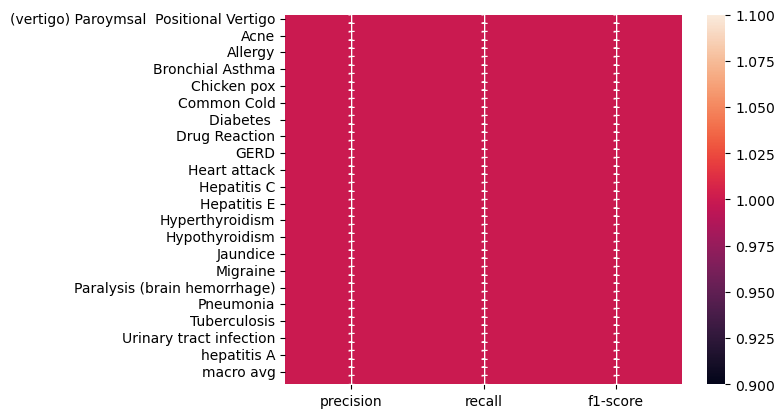

In [56]:
from sklearn.metrics import classification_report
import seaborn as sns

print("Model 1:")
p = model4.predict(X_unseen)
clf_report  = classification_report(y_unseen, tf.argmax(p, axis=1),target_names=class_names, output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)


In [57]:
#### Print confusion matrix

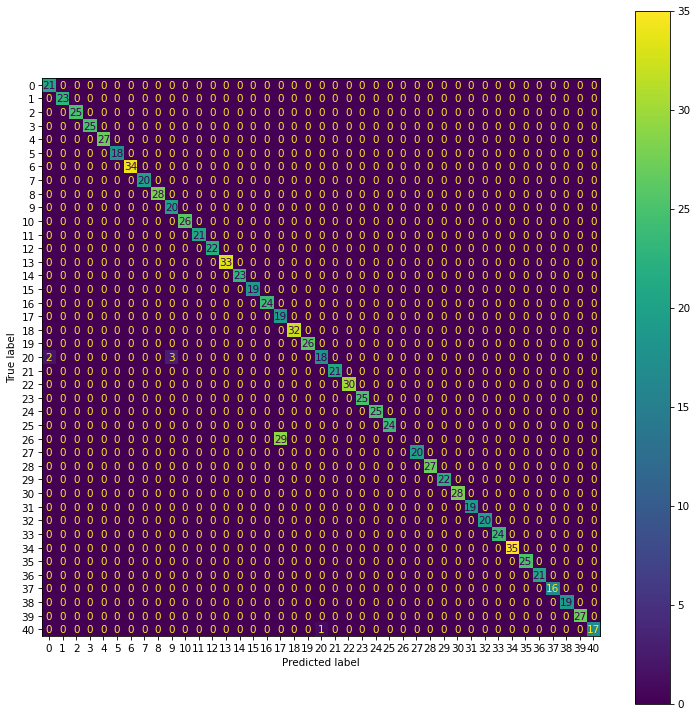

In [58]:
figsize=[12,12]
cm = confusion_matrix(y_test, predicted11) 
cm_display = ConfusionMatrixDisplay(cm).plot(ax=plt.subplots(figsize=figsize, dpi=75)[1])


In [59]:
#fig, axn = plt.subplots(3,3, sharex=True, sharey=True,figsize=(12,12))

#for i, ax in enumerate(axn.flat):
#    k = list(cf_matrix)[i]
#    sns.heatmap(cf_matrix[k], ax=ax,cbar=i==4)
#    ax.set_title(k,fontsize=8)
